In [ ]:
### requires scikit-learn>=1.3 for HDBSCAN

In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import skew, kurtosis, norm
from sklearn.cluster import DBSCAN, HDBSCAN
from sklearn.preprocessing import quantile_transform
import shap
import hdbscan
%matplotlib inline

/home/benjb/.conda/envs/sklearn-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
skews = np.load('/datax/scratch/benjb/skewnesses.npz')['arr_0']
kurts = np.load('/datax/scratch/benjb/kurtoses.npz')['arr_0']
sarles = np.load('/datax/scratch/benjb/sarles.npz')['arr_0']
corrs = np.load('/datax/scratch/benjb/new_new_corrs.npz')['arr_0']
tbws = np.load('/datax/scratch/benjb/new_new_tbws.npz')['arr_0']
tskews = np.load('/datax/scratch/benjb/temporal_skewnesses.npz')['arr_0']
tstds = np.load('/datax/scratch/benjb/tstds.npz')['arr_0']
fstds = np.load('/datax/scratch/benjb/fstds.npz')['arr_0']
sigbws = np.load('/datax/scratch/benjb/MESSIER031_00_signal_bws.npz')['arr_0']

In [3]:
print(len(skews))

3068


In [4]:
prefix = 'setigen'
skews = np.concatenate((skews, np.load(f'/datax/scratch/benjb/{prefix}_skewnesses.npz')['arr_0']))
kurts = np.concatenate((kurts, np.load(f'/datax/scratch/benjb/{prefix}_kurtoses.npz')['arr_0']))
sarles = np.concatenate((sarles, np.load(f'/datax/scratch/benjb/{prefix}_sarles.npz')['arr_0']))
corrs = np.concatenate((corrs, np.load(f'/datax/scratch/benjb/{prefix}_corrs.npz')['arr_0']))
tbws = np.concatenate((tbws, np.load(f'/datax/scratch/benjb/{prefix}_tbws.npz')['arr_0']))
tskews = np.concatenate((tskews, np.load(f'/datax/scratch/benjb/{prefix}_tskews.npz')['arr_0']))
tstds = np.concatenate((tstds, np.load(f'/datax/scratch/benjb/{prefix}_tstds.npz')['arr_0']))
fstds = np.concatenate((fstds, np.load(f'/datax/scratch/benjb/{prefix}_fstds.npz')['arr_0']))
sigbws = np.concatenate((sigbws, np.load(f'/datax/scratch/benjb/{prefix}_signal_bws.npz')['arr_0']))

In [5]:
print(len(skews))

3071


In [6]:
prefix = 'HIP3223'
skews = np.concatenate((skews, np.load(f'/datax/scratch/benjb/{prefix}_skewnesses.npz')['arr_0']))
kurts = np.concatenate((kurts, np.load(f'/datax/scratch/benjb/{prefix}_kurtoses.npz')['arr_0']))
sarles = np.concatenate((sarles, np.load(f'/datax/scratch/benjb/{prefix}_sarles.npz')['arr_0']))
corrs = np.concatenate((corrs, np.load(f'/datax/scratch/benjb/{prefix}_corrs.npz')['arr_0']))
tbws = np.concatenate((tbws, np.load(f'/datax/scratch/benjb/{prefix}_tbws.npz')['arr_0']))
tskews = np.concatenate((tskews, np.load(f'/datax/scratch/benjb/{prefix}_tskews.npz')['arr_0']))
tstds = np.concatenate((tstds, np.load(f'/datax/scratch/benjb/{prefix}_tstds.npz')['arr_0']))
fstds = np.concatenate((fstds, np.load(f'/datax/scratch/benjb/{prefix}_fstds.npz')['arr_0']))
sigbws = np.concatenate((sigbws, np.load(f'/datax/scratch/benjb/{prefix}_signal_bws.npz')['arr_0']))

In [7]:
print(len(skews))

3387


In [8]:
prefix = 'HIP2792'
skews = np.concatenate((skews, np.load(f'/datax/scratch/benjb/{prefix}_skewnesses.npz')['arr_0']))
kurts = np.concatenate((kurts, np.load(f'/datax/scratch/benjb/{prefix}_kurtoses.npz')['arr_0']))
sarles = np.concatenate((sarles, np.load(f'/datax/scratch/benjb/{prefix}_sarles.npz')['arr_0']))
corrs = np.concatenate((corrs, np.load(f'/datax/scratch/benjb/{prefix}_corrs.npz')['arr_0']))
tbws = np.concatenate((tbws, np.load(f'/datax/scratch/benjb/{prefix}_tbws.npz')['arr_0']))
tskews = np.concatenate((tskews, np.load(f'/datax/scratch/benjb/{prefix}_tskews.npz')['arr_0']))
tstds = np.concatenate((tstds, np.load(f'/datax/scratch/benjb/{prefix}_tstds.npz')['arr_0']))
fstds = np.concatenate((fstds, np.load(f'/datax/scratch/benjb/{prefix}_fstds.npz')['arr_0']))
sigbws = np.concatenate((sigbws, np.load(f'/datax/scratch/benjb/{prefix}_signal_bws.npz')['arr_0']))

In [9]:
print(len(sigbws))

6396


In [10]:
lfiles = ['/datag/pipeline/AGBT19B_999_121/blc73_blp03/blc73_guppi_58832_16209_MESSIER031_0057.gpuspec.0000.h5',
'/datag/pipeline/AGBT19B_999_121/blc73_blp03/blc73_guppi_58832_16530_HIP2792_0058.gpuspec.0000.h5',
'/datag/pipeline/AGBT19B_999_121/blc73_blp03/blc73_guppi_58832_16851_MESSIER031_0059.gpuspec.0000.h5',
'/datag/pipeline/AGBT19B_999_121/blc73_blp03/blc73_guppi_58832_17168_HIP3077_0060.gpuspec.0000.h5',
'/datag/pipeline/AGBT19B_999_121/blc73_blp03/blc73_guppi_58832_17485_MESSIER031_0061.gpuspec.0000.h5',
'/datag/pipeline/AGBT19B_999_121/blc73_blp03/blc73_guppi_58832_17801_HIP3223_0062.gpuspec.0000.h5']

filename = '/datax/scratch/benjb/m31_l_data/' + lfiles[0][44:-2] + 'dat'

df0 = pd.read_table(filename, sep='\s+', names=['Top_Hit_#','Drift_Rate','SNR','Uncorrected_Frequency','Corrected_Frequency',
                                            'Index', 'freq_start', 'freq_end', 'SEFD', 'SEFD_freq', 'Coarse_Channel_Number', 
                                            'Full_number_of_hits'], skiprows=9)

freqs = df0['Uncorrected_Frequency'].values
drifts = df0['Drift_Rate'].values
snrs = df0['SNR'].values

<>:10: SyntaxWarning: invalid escape sequence '\s'
<>:10: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_292138/3868843571.py:10: SyntaxWarning: invalid escape sequence '\s'
  df0 = pd.read_table(filename, sep='\s+', names=['Top_Hit_#','Drift_Rate','SNR','Uncorrected_Frequency','Corrected_Frequency',


In [11]:
df1 = pd.read_table('/datax/scratch/benjb/m31_observation_with_setigen.dat', sep='\s+', names=['Top_Hit_#','Drift_Rate','SNR','Uncorrected_Frequency','Corrected_Frequency',
                                            'Index', 'freq_start', 'freq_end', 'SEFD', 'SEFD_freq', 'Coarse_Channel_Number', 
                                            'Full_number_of_hits'], skiprows=9)

top_hit_no = df1['Top_Hit_#'].values

stg_idxs = np.where((top_hit_no == 111) | (top_hit_no == 1743) | (top_hit_no == 362))[0]

freqs = np.concatenate((freqs, df1['Uncorrected_Frequency'].values[stg_idxs]))
drifts = np.concatenate((drifts, df1['Drift_Rate'].values[stg_idxs]))
snrs = np.concatenate((snrs, df1['SNR'].values[stg_idxs]))

<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_292138/3130409983.py:1: SyntaxWarning: invalid escape sequence '\s'
  df1 = pd.read_table('/datax/scratch/benjb/m31_observation_with_setigen.dat', sep='\s+', names=['Top_Hit_#','Drift_Rate','SNR','Uncorrected_Frequency','Corrected_Frequency',


In [12]:
df2 = pd.read_table('/datax/scratch/benjb/m31_l_data/' + lfiles[5][44:-2] + 'dat', sep='\s+', names=['Top_Hit_#','Drift_Rate','SNR','Uncorrected_Frequency','Corrected_Frequency',
                                            'Index', 'freq_start', 'freq_end', 'SEFD', 'SEFD_freq', 'Coarse_Channel_Number', 
                                            'Full_number_of_hits'], skiprows=9)

df2_idxs = np.where((df2['Uncorrected_Frequency'].values > 1590) & (df2['Uncorrected_Frequency'].values < 1610))[0]

freqs = np.concatenate((freqs, df2['Uncorrected_Frequency'].values[df2_idxs]))
drifts = np.concatenate((drifts, df2['Drift_Rate'].values[df2_idxs]))
snrs = np.concatenate((snrs, df2['SNR'].values[df2_idxs]))

<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_292138/2583672721.py:1: SyntaxWarning: invalid escape sequence '\s'
  df2 = pd.read_table('/datax/scratch/benjb/m31_l_data/' + lfiles[5][44:-2] + 'dat', sep='\s+', names=['Top_Hit_#','Drift_Rate','SNR','Uncorrected_Frequency','Corrected_Frequency',


In [13]:
df3 = pd.read_table('/datax/scratch/benjb/m31_l_data/' + lfiles[1][44:-2] + 'dat', sep='\s+', names=['Top_Hit_#','Drift_Rate','SNR','Uncorrected_Frequency','Corrected_Frequency',
                                            'Index', 'freq_start', 'freq_end', 'SEFD', 'SEFD_freq', 'Coarse_Channel_Number', 
                                            'Full_number_of_hits'], skiprows=9)

print(lfiles[1][44:-2])

freqs = np.concatenate((freqs, df3['Uncorrected_Frequency'].values))
drifts = np.concatenate((drifts, df3['Drift_Rate'].values))
snrs = np.concatenate((snrs, df3['SNR'].values))

blc73_guppi_58832_16530_HIP2792_0058.gpuspec.0000.


<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_292138/564282688.py:1: SyntaxWarning: invalid escape sequence '\s'
  df3 = pd.read_table('/datax/scratch/benjb/m31_l_data/' + lfiles[1][44:-2] + 'dat', sep='\s+', names=['Top_Hit_#','Drift_Rate','SNR','Uncorrected_Frequency','Corrected_Frequency',


In [14]:
print(len(freqs))

6396


In [15]:
normal_drifts = quantile_transform(drifts.reshape(len(drifts), 1), n_quantiles=len(drifts), output_distribution='normal')
normal_drifts = normal_drifts.reshape(len(normal_drifts))

reds = np.load('/datax/scratch/benjb/ls_rednesses.npy', allow_pickle=True)
reds = np.abs(np.nan_to_num(reds, nan=0.1))
#for i in range(len(reds)):
#    if reds[i] == 0:
#        reds[i] = 0.01

data_arr = np.array([np.argsort(np.argsort(freqs))/len(freqs),
                     #0.1*(freqs-np.min(freqs))/np.max(freqs-np.min(freqs)), 
                     np.abs(normal_drifts)/np.max(np.abs(normal_drifts)), 
                     (np.log10(snrs)-np.min(np.log10(snrs)))/np.max(np.log10(snrs)-np.min(np.log10(snrs))), 
                     (skews-np.min(skews))/np.max((skews-np.min(skews))), 
                     (np.log10(kurts)-np.min(np.log10(kurts)))/np.max(np.log10(kurts)-np.min(np.log10(kurts))), 
                     sarles, 
                     corrs, 
                     (np.log10(tbws*1e6)-np.min(np.log10(tbws*1e6)))/np.max(np.log10(tbws*1e6)-np.min(np.log10(tbws*1e6))),
                     (tskews-np.min(tskews))/np.max((tskews-np.min(tskews))),
                     (np.log10(tstds)-np.min(np.log10(tstds))),
                     (np.log10(fstds)-np.min(np.log10(fstds))),
                     sigbws/np.max(sigbws),
                     (np.log10(reds)-np.min(np.log10(reds)))/(np.max(np.log10(reds))-np.min(np.log10(reds)))
                     ])  ### PRE-PROCESSED FOR HDBSCAN

data_arr_unscaled = np.array([freqs, 
                     drifts, 
                     snrs, 
                     skews, 
                     kurts, 
                     sarles, 
                     corrs, 
                     tbws*1e6,
                     tskews,
                     tstds,
                     fstds,
                     sigbws,
                     reds
                     ])

df = pd.DataFrame(np.transpose(data_arr),
                   columns=['frequency [MHz]', 
                            'drift rate [Hz/s]', 
                            'log10 SNR', 
                            'skewness', 
                            'log10 kurtosis', 
                            'Sarle\'s coefficient', 
                            'correlation coefficient [kurtosis vs. log(bandwidth)]', 
                            'log10 turning-point bandwidth [Hz]', 
                            'temporal skewness', 
                            'log10 time-series standard deviation', 
                            'log10 power-spectrum standard deviation',
                            'signal bandwidth',
                            'log10 redness of spectral periodogram'])

dfu = pd.DataFrame(np.transpose(data_arr_unscaled),
                   columns=['frequency [MHz]', 
                            'drift rate [Hz/s]', 
                            'SNR', 
                            'spectral skewness', 
                            'spectral kurtosis', 
                            'bimodality coefficient', 
                            'correlation coefficient', 
                            'turning-point bandwidth [Hz]', 
                            'temporal skewness', 
                            'temporal standard deviation', 
                            'spectral standard deviation',
                            'signal bandwidth [Hz]',
                            'redness of spectral periodogram'])

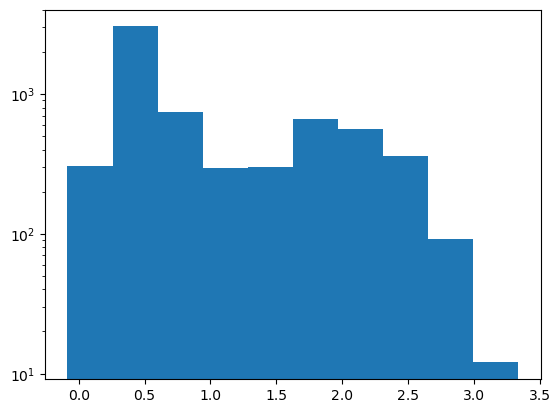

In [37]:
plt.hist(np.log10(reds))
plt.yscale('log')
plt.show()

In [84]:
df

,frequency [MHz],drift rate [Hz/s],log10 SNR,skewness,log10 kurtosis,Sarle's coefficient,correlation coefficient [kurtosis vs. log(bandwidth)],log10 turning-point bandwidth [Hz],temporal skewness,log10 time-series standard deviation,log10 power-spectrum standard deviation,signal bandwidth
0,0.999844,0.393401,0.030133,0.312040,0.699076,0.573581,0.988025,0.926634,0.435718,0.231763,0.249675,0.011215
1,0.999687,0.384936,0.023068,0.253899,0.639559,0.521328,0.982859,1.000000,0.405463,0.265949,0.284966,0.016822
2,0.999531,0.393401,0.042302,0.250583,0.610463,0.612942,0.973850,1.000000,0.323279,0.460191,0.357574,0.014953
3,0.999375,0.384936,0.106724,0.438090,0.765956,0.798978,0.973628,1.000000,0.326385,0.488768,0.232137,0.016822
4,0.999218,0.393401,0.017419,0.234020,0.638220,0.430768,0.993980,0.962119,0.430675,0.236163,0.272045,0.024299
...,...,...,...,...,...,...,...,...,...,...,...,...
6391,0.001251,0.080464,0.223711,0.303216,0.639405,0.797981,0.682940,1.000000,0.330628,0.326150,0.360673,0.014953
6392,0.001094,0.080464,0.202353,0.279027,0.607708,0.809192,0.967184,0.699952,0.378201,0.282790,0.400208,0.020561
6393,0.000625,0.080464,0.112979,0.924283,0.983424,0.946084,0.955748,0.890342,0.584980,0.142111,0.012021,0.005607
6394,0.000469,0.080464,0.190027,0.695650,0.888378,0.973365,0.951043,1.000000,0.387545,0.282772,0.140863,0.020561


[0.47888885 0.71205627 0.80292108 0.86424123 0.91552918 0.94982357
 0.96387683 0.97637915 0.98655709 0.99246859 0.9962915  0.99910162
 1.        ]
[0.30760939 0.14977272 0.05836609 0.03938837 0.03294429 0.02202865
 0.00902697 0.00803074 0.0065377  0.00379719 0.0024556  0.00180505
 0.00057706]


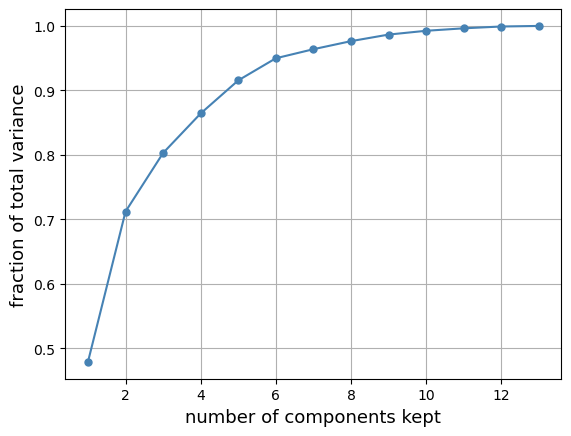

(6396, 13)
(6396, 6)


In [20]:
from sklearn.decomposition import PCA

X = np.transpose(data_arr)
X_reduced = PCA(n_components=6, svd_solver='full').fit_transform(X)
pca = PCA()
pca.fit(X)
variances = pca.explained_variance_
cumulative_variance = [np.sum(variances[:i+1]) for i in range(len(variances))]
print(np.array(cumulative_variance)/np.sum(variances))

print(variances)

plt.plot(np.arange(len(variances))+1, np.array(cumulative_variance)/np.sum(variances), '.-', c='steelblue', markersize=10)
plt.grid()
plt.ylabel('fraction of total variance', size='13')
plt.xlabel('number of components kept', size='13')
plt.savefig('/datax/scratch/benjb/PCA_with_13_features.pdf', bbox_inches='tight')
plt.show()

print(np.shape(X))
print(np.shape(X_reduced))

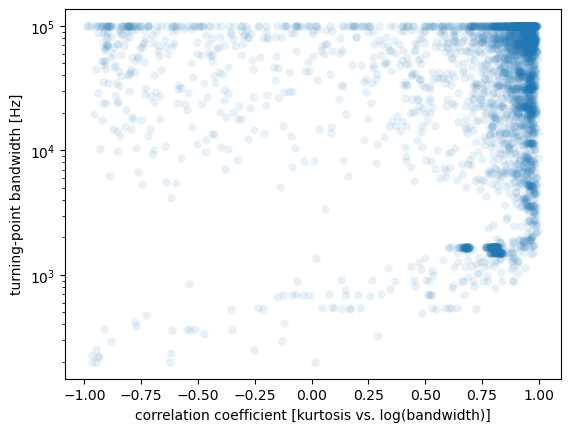

In [97]:
p1 = dfu.columns[6]
p2 = dfu.columns[7]
plt.scatter(dfu[p1].values, dfu[p2].values, alpha=0.1, linewidths=0)
#plt.xscale('log')
plt.yscale('log')
plt.xlabel(p1)
plt.ylabel(p2)
plt.show()

Fitting ...
Making labels ...
Scattering ...
Refining ...


/tmp/ipykernel_2131849/764598378.py:47: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in leg.legendHandles:


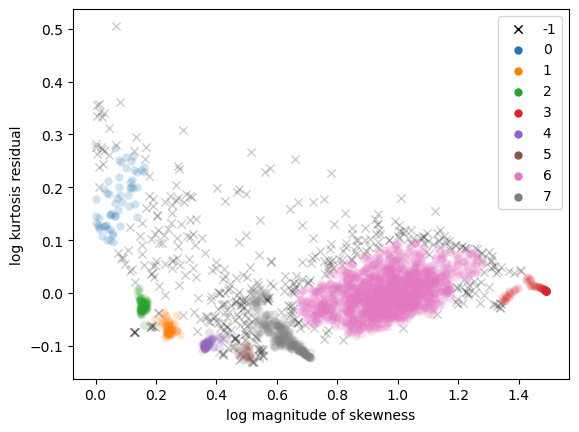

In [70]:
hdb = HDBSCAN(min_cluster_size=20, min_samples=20)

cut = 1

coef = np.polyfit(np.log10(np.abs(skews)[np.where(np.abs(skews) > cut)[0]]), np.log10(kurts[np.where(np.abs(skews) > cut)[0]]), 1)
poly1d_fn = np.poly1d(coef)

xunsorted = np.abs(skews)[np.where(np.abs(skews) > cut)[0]]
xmodunsorted = np.log10(xunsorted)
ymodunsorted = poly1d_fn(xmodunsorted)
yunsorted = 10**ymodunsorted

x = np.log10(np.abs(skews)[np.where(np.abs(skews) > cut)[0]])
y = np.log10(kurts[np.where(np.abs(skews) > cut)[0]]) - ymodunsorted

print('Fitting ...')

X = np.transpose(np.array([x, y]))
hdb.fit(X)

#labels = hdb.labels_
print('Making labels ...')
labels_list = hdb.labels_
labels = np.unique(labels_list)
#print(labels)

print('Scattering ...')
for l in labels:
    idxs = np.where(labels_list == l)
    #print(idxs)
    if l == -1.:
        plt.scatter(x[idxs], y[idxs], color='k', marker='x', alpha=0.2, linewidths=1, label=l)
    else:
        plt.scatter(x[idxs], y[idxs], alpha=0.2, linewidths=0, label=l)

print('Refining ...')

#plt.xscale('log')
#plt.yscale('log')
#plt.xlabel('skewness')
#plt.ylabel('kurtosis')

plt.xlabel('log magnitude of skewness')
plt.ylabel('log kurtosis residual')

leg = plt.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)

plt.show()

Fitting ...
Making labels ...
Scattering ...
Refining ...


/tmp/ipykernel_2131849/3448131167.py:52: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in leg.legendHandles:


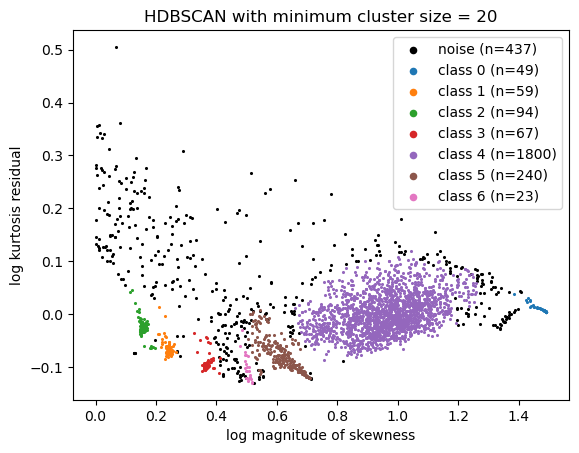

In [102]:
nmincluster = 20
hdb = HDBSCAN(min_cluster_size=nmincluster, min_samples=nmincluster)

cut = 1

coef = np.polyfit(np.log10(np.abs(skews)[np.where(np.abs(skews) > cut)[0]]), np.log10(kurts[np.where(np.abs(skews) > cut)[0]]), 1)
poly1d_fn = np.poly1d(coef)

xunsorted = np.abs(skews)[np.where(np.abs(skews) > cut)[0]]
xmodunsorted = np.log10(xunsorted)
ymodunsorted = poly1d_fn(xmodunsorted)
yunsorted = 10**ymodunsorted

x = np.log10(np.abs(skews)[np.where(np.abs(skews) > cut)[0]])
y = np.log10(kurts[np.where(np.abs(skews) > cut)[0]]) - ymodunsorted

#x = np.abs(skews)[np.where(np.abs(skews) > cut)[0]]
#y = kurts[np.where(np.abs(skews) > cut)[0]]

print('Fitting ...')

X = np.transpose(np.array([x, y+ymodunsorted]))
hdb.fit(X)

#labels = hdb.labels_
print('Making labels ...')
labels_list = hdb.labels_
labels = np.unique(labels_list)
#print(labels)

print('Scattering ...')
for l in labels:
    idxs = np.where(labels_list == l)[0]
    #print(idxs)
    if l == -1.:
        plt.scatter(x[idxs], y[idxs], color='k', s=5, linewidths=0, label=f'noise (n={len(idxs)})')
    else:
        plt.scatter(x[idxs], y[idxs], s=5, linewidths=0, label=f'class {l} (n={len(idxs)})')

print('Refining ...')

#plt.xscale('log')
#plt.yscale('log')
#plt.xlabel('skewness')
#plt.ylabel('kurtosis')

plt.xlabel('log magnitude of skewness')
plt.ylabel('log kurtosis residual')
plt.title(f'HDBSCAN with minimum cluster size = {nmincluster}')

leg = plt.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)
    lh.set_sizes([30])

plt.show()

In [29]:
for ii, name in enumerate(dfu.columns):
    print(f'{ii}: {name}')

0: frequency [MHz]
1: drift rate [Hz/s]
2: SNR
3: spectral skewness
4: spectral kurtosis
5: Sarle's coefficient
6: correlation coefficient [kurtosis vs. log(bandwidth)]
7: turning-point bandwidth [Hz]
8: temporal skewness
9: time-series standard deviation
10: power-spectrum standard deviation
11: signal bandwidth


In [61]:
hyperparam_space = []

for nmincluster in np.arange(start=2, stop=13, step=1):
    for nminsamples in np.arange(start=1, stop=5, step=1):
        for eps in np.arange(start=0, stop=0.2, step=0.01):

            #print(f'nmincluster = {nmincluster}, nminsamples = {nminsamples}, eps = {eps}')

            hdb = HDBSCAN(min_cluster_size=nmincluster, min_samples=nminsamples, cluster_selection_epsilon=eps, cluster_selection_method='leaf')

            X = np.transpose(data_arr)
            #hdb.fit(X[:,1:])
            hdb.fit(X)
            
            labels_list = hdb.labels_

            n_anomalies = len(np.where(labels_list==-1)[0])

            #print(n_anomalies)

            if labels_list[3068] == labels_list[3069] == labels_list[3070]:
                recovery = True
            else:
                recovery = False

            hyperparams = np.array([n_anomalies, nmincluster, nminsamples, eps, recovery])
            print(hyperparams)
            hyperparam_space.append(hyperparams)


[982.   2.   1.   0.   0.]
[9.82e+02 2.00e+00 1.00e+00 1.00e-02 0.00e+00]
[9.52e+02 2.00e+00 1.00e+00 2.00e-02 0.00e+00]
[9.03e+02 2.00e+00 1.00e+00 3.00e-02 0.00e+00]
[8.56e+02 2.00e+00 1.00e+00 4.00e-02 0.00e+00]
[8.51e+02 2.00e+00 1.00e+00 5.00e-02 0.00e+00]
[8.42e+02 2.00e+00 1.00e+00 6.00e-02 0.00e+00]
[8.28e+02 2.00e+00 1.00e+00 7.00e-02 0.00e+00]
[7.87e+02 2.00e+00 1.00e+00 8.00e-02 0.00e+00]
[7.25e+02 2.00e+00 1.00e+00 9.00e-02 0.00e+00]
[6.52e+02 2.00e+00 1.00e+00 1.00e-01 0.00e+00]
[5.72e+02 2.00e+00 1.00e+00 1.10e-01 0.00e+00]
[4.94e+02 2.00e+00 1.00e+00 1.20e-01 0.00e+00]
[4.14e+02 2.00e+00 1.00e+00 1.30e-01 0.00e+00]
[3.57e+02 2.00e+00 1.00e+00 1.40e-01 0.00e+00]
[3.0e+02 2.0e+00 1.0e+00 1.5e-01 0.0e+00]
[2.65e+02 2.00e+00 1.00e+00 1.60e-01 0.00e+00]
[2.26e+02 2.00e+00 1.00e+00 1.70e-01 0.00e+00]
[2.0e+02 2.0e+00 1.0e+00 1.8e-01 0.0e+00]
[163.     2.     1.     0.19   0.  ]
[982.   2.   2.   0.   0.]
[9.82e+02 2.00e+00 2.00e+00 1.00e-02 0.00e+00]
[9.52e+02 2.00e+00 2.00e+0

In [62]:
hyperparam_space = np.array(hyperparam_space)

In [48]:
idxs = np.argsort(hyperparam_space[:,0])
sorted_hyperparam_space = hyperparam_space[idxs]
for i in range(15):
    print(sorted_hyperparam_space[i])

[54.    2.    2.    0.29  0.  ]
[62.   10.    2.    0.29  0.  ]
[62.   12.    2.    0.28  0.  ]
[62.   12.    2.    0.26  0.  ]
[62.   12.    2.    0.29  0.  ]
[62.   11.    2.    0.29  0.  ]
[62.    9.    2.    0.29  0.  ]
[62.   12.    2.    0.27  0.  ]
[65.    7.    2.    0.29  0.  ]
[65.    5.    2.    0.29  0.  ]
[65.    6.    2.    0.29  0.  ]
[65.    8.    2.    0.29  0.  ]
[66.    4.    2.    0.29  0.  ]
[69.    3.    2.    0.29  1.  ]
[71.    2.    2.    0.28  0.  ]


In [63]:
def find_optimum_hyperparams(hyperparam_space):
    idxs = np.argsort(hyperparam_space[:,0])
    sorted_hyperparam_space = hyperparam_space[idxs]
    optimum_idx = np.argmax(sorted_hyperparam_space[:,4])
    optimum_hyperparams = sorted_hyperparam_space[optimum_idx]
    return optimum_hyperparams

print(find_optimum_hyperparams(hyperparam_space))

[2.17e+02 3.00e+00 1.00e+00 1.90e-01 1.00e+00]


(3387, 13)
Making labels ...
24
Scattering ...
322
Refining ...


/tmp/ipykernel_292138/241752119.py:77: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in leg.legendHandles:


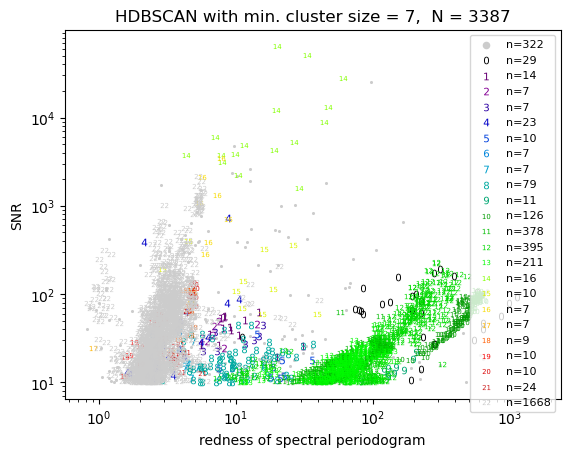

In [72]:
import matplotlib.cm as cm

nmincluster = 7
nminsamples = 2
#eps = 0.1794 # (for the 6k dataset)
eps = 0.24

#nmincluster = 11
#nminsamples = 2
#eps = 0.18

col_idx_x = 12
col_idx_y = 2

#hdb = HDBSCAN(min_cluster_size=nmincluster, min_samples=nminsamples, cluster_selection_epsilon=eps, cluster_selection_method='eom', store_centers='centroid')
#hdb = hdbscan.HDBSCAN(min_cluster_size=nmincluster, min_samples=nminsamples, cluster_selection_epsilon=eps, cluster_selection_method='eom', store_centers='centroid', prediction_data=True).fit(X)

#x_idxs = np.random.choice(np.arange(3071), 200, replace=False)
#X = np.transpose(data_arr)[x_idxs]
X = np.transpose(data_arr)[:3387]
#hdb.fit(np.concatenate((X[:,1:], X[:,2:]), axis=1))
#hdb.fit(X[:,1:])
#model = hdb.fit(X)
#hdb.fit(X_reduced)
# 901, 3911

print(np.shape(X))

hdb = hdbscan.HDBSCAN(min_cluster_size=nmincluster, min_samples=nminsamples, cluster_selection_epsilon=eps, cluster_selection_method='eom', prediction_data=True).fit(X)

print('Making labels ...')
labels_list = hdb.labels_
labels = np.unique(labels_list)
print(len(labels))

x_param = dfu.columns[col_idx_x]
y_param = dfu.columns[col_idx_y]

x = dfu[x_param].values
y = dfu[y_param].values

colors = cm.nipy_spectral(np.linspace(0, 1, len(labels)-1))

print('Scattering ...')
for l in labels:
    idxs = np.where(labels_list == l)[0]
    if l == -1.:
        plt.scatter(x[idxs], y[idxs], color='0.8', s=5, linewidths=0, label=f'n={len(idxs)}')
        print(len(idxs))
    else:
        plt.scatter(x[idxs], y[idxs], marker=f'${l}$', color=colors[l], s=30, linewidths=0, label=f'n={len(idxs)}')

#other_idxs = np.array([683, 691])
other_idxs = np.array([3068, 3069, 3070])
#other_idxs = np.where(labels_list==11)[0]
#other_idxs2 = np.where(labels_list==12)[0]

#plt.scatter(x[other_idxs], y[other_idxs], color='k', edgecolors='w', linewidths=0.4, s=30, marker='X')
#plt.scatter(x[other_idxs2], y[other_idxs2], color='w', edgecolors='k', s=30, marker='X')

print('Refining ...')

if 'log10' in df.columns[col_idx_x]:
    plt.xscale('log')
else:
    plt.xscale('linear')
if 'log10' in df.columns[col_idx_y]:
    plt.yscale('log')
else:
    plt.yscale('linear')

plt.xlabel(x_param)
plt.ylabel(y_param)
plt.title(f'HDBSCAN with min. cluster size = {nmincluster},  N = {len(X)}')

leg = plt.legend(fontsize=8)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
    lh.set_sizes([30])
#plt.xscale('log')
#plt.yscale('log')

#plt.savefig(f'HDBSCAN_clustering_{col_idx_x}_{col_idx_y}.pdf')

plt.show()

(3387, 13)
Making labels ...
24
Scattering ...
322
Refining ...


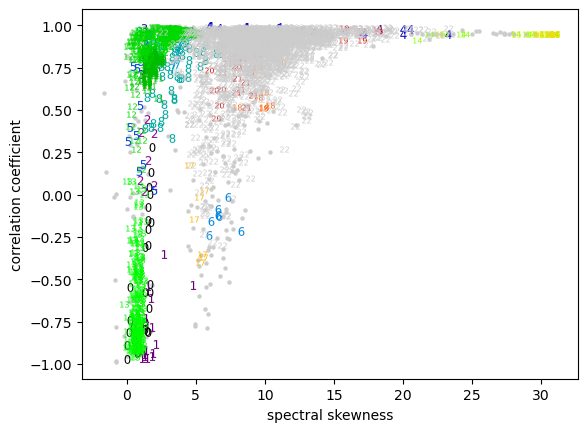

In [95]:
import matplotlib.cm as cm

nmincluster = 7
nminsamples = 2
#eps = 0.1794 # (for the 6k dataset)
eps = 0.24

#nmincluster = 11
#nminsamples = 2
#eps = 0.18

col_idx_x = 3
col_idx_y = 6

#hdb = HDBSCAN(min_cluster_size=nmincluster, min_samples=nminsamples, cluster_selection_epsilon=eps, cluster_selection_method='eom', store_centers='centroid')
#hdb = hdbscan.HDBSCAN(min_cluster_size=nmincluster, min_samples=nminsamples, cluster_selection_epsilon=eps, cluster_selection_method='eom', store_centers='centroid', prediction_data=True).fit(X)

#x_idxs = np.random.choice(np.arange(3071), 200, replace=False)
#X = np.transpose(data_arr)[x_idxs]
X = np.transpose(data_arr)[:3387]
#hdb.fit(np.concatenate((X[:,1:], X[:,2:]), axis=1))
#hdb.fit(X[:,1:])
#model = hdb.fit(X)
#hdb.fit(X_reduced)
# 901, 3911

print(np.shape(X))

hdb = hdbscan.HDBSCAN(min_cluster_size=nmincluster, min_samples=nminsamples, cluster_selection_epsilon=eps, cluster_selection_method='eom', prediction_data=True).fit(X)

print('Making labels ...')
labels_list = hdb.labels_
labels = np.unique(labels_list)
print(len(labels))

x_param = dfu.columns[col_idx_x]
y_param = dfu.columns[col_idx_y]

x = dfu[x_param].values
y = dfu[y_param].values

colors = cm.nipy_spectral(np.linspace(0, 1, len(labels)-1))

print('Scattering ...')
for l in labels:
    idxs = np.where(labels_list == l)[0]
    if l == -1.:
        plt.scatter(x[idxs], y[idxs], color='0.8', s=10, linewidths=0, label=f'n={len(idxs)}')
        print(len(idxs))
    else:
        plt.scatter(x[idxs], y[idxs], marker=f'${l}$', color=colors[l], s=40, linewidths=0, label=f'n={len(idxs)}')

#other_idxs = np.array([683, 691])
other_idxs = np.array([3068, 3069, 3070])
#other_idxs = np.where(labels_list==11)[0]
#other_idxs2 = np.where(labels_list==12)[0]

#plt.scatter(x[other_idxs], y[other_idxs], color='k', edgecolors='w', linewidths=0.4, s=30, marker='X')
#plt.scatter(x[other_idxs2], y[other_idxs2], color='w', edgecolors='k', s=30, marker='X')

print('Refining ...')

if 'log10' in df.columns[col_idx_x]:
    plt.xscale('log')
else:
    plt.xscale('linear')
if 'log10' in df.columns[col_idx_y]:
    plt.yscale('log')
else:
    plt.yscale('linear')

plt.xlabel(x_param)
plt.ylabel(y_param)
#plt.title(f'HDBSCAN with min. cluster size = {nmincluster},  N = {len(X)}')

#leg = plt.legend(fontsize=8)
#for lh in leg.legendHandles: 
#    lh.set_alpha(1)
#    lh.set_sizes([30])
#plt.xscale('log')
#plt.yscale('log')

#plt.savefig(f'HDBSCAN_clustering_{col_idx_x}_{col_idx_y}.pdf')

plt.show()

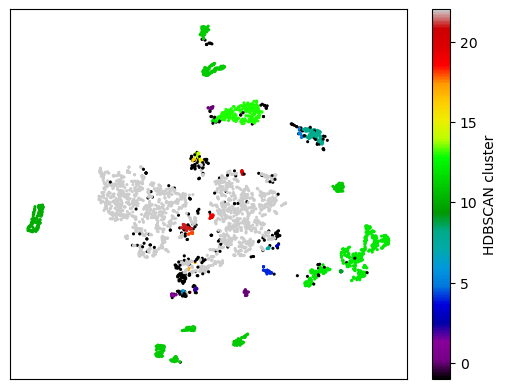

In [84]:
from sklearn.manifold import TSNE

xembed = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=40, early_exaggeration=1).fit_transform(X)

fig, ax = plt.subplots()
s = ax.scatter(xembed[:,0], xembed[:,1], 
            c=hdb.labels_,
            cmap='nipy_spectral',
            #vmin=-0.5, vmax=14.5,
            s=5, linewidths=0, alpha=1)
ax.set_xticks([])
ax.set_yticks([])
fig.colorbar(mappable=s, label=r'HDBSCAN cluster', ax=ax)
plt.show()

In [71]:
print(labels_list[other_idxs])

[-1 -1 -1]


In [31]:
print(X.shape)

(3387, 13)


In [96]:
#explainer = shap.Explainer(hdb.fit, X)
#shap_values = explainer(X)

feature_names = ['frequency', 
                'drift rate', 
                'SNR', 
                'spectral skewness', 
                'spectral kurtosis', 
                'bimodality coeff.', 
                'correlation coeff.', 
                'turning-pt. bandwidth', 
                'temporal skewness', 
                'temporal std. deviation', 
                'spectral std. deviation',
                'signal bandwidth',
                'redness of periodogram']

X100 = shap.utils.sample(X, 100)
X20 = shap.utils.sample(X, 20)

def hdbscan_predict(X):
    return hdbscan.approximate_predict(hdb,X)[0]
explainer = shap.KernelExplainer(model=hdbscan_predict, data=X100, feature_names=feature_names)
#shap_values = explainer.shap_values(X)


100%|██████████| 400/400 [2:38:02<00:00, 23.71s/it]  


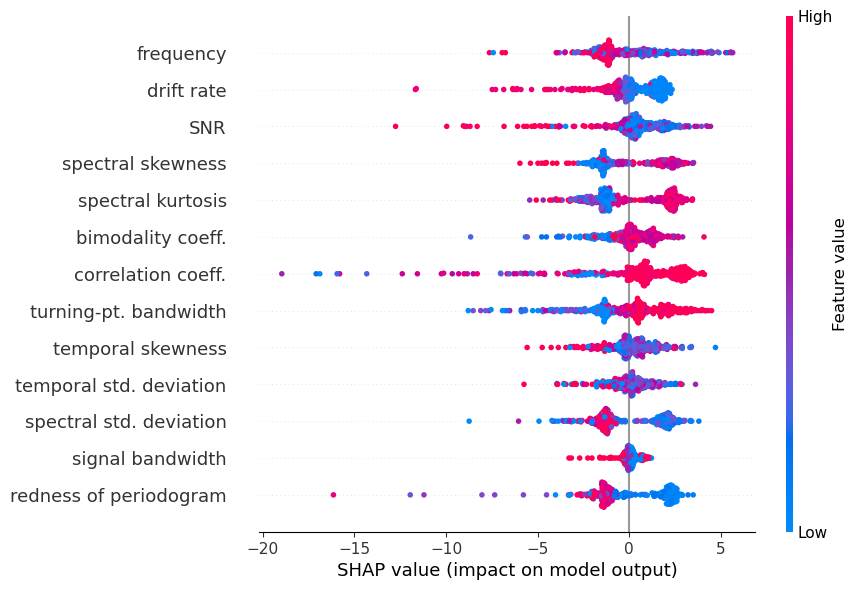

In [102]:
shap.plots.beeswarm(explainer(shap.sample(X,400)), max_display=20, order=np.arange(len(dfu.columns)), show=False)
plt.savefig('/datax/scratch/benjb/SHAP_feature_importances_n400_new_redness.pdf', bbox_inches='tight')

100%|██████████| 200/200 [01:00<00:00,  3.31it/s]


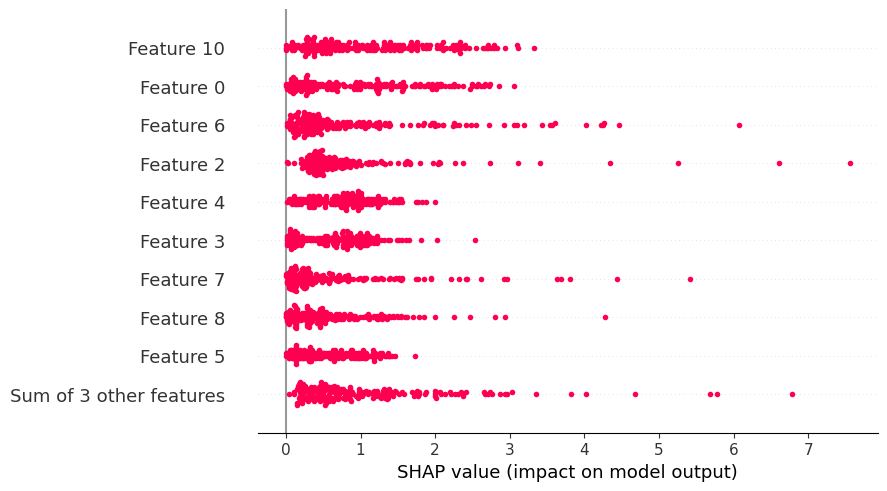

In [65]:
shap.plots.beeswarm(explainer(X).abs, color="steelblue", max_display=20)

In [28]:
np.savez(f'/datax/scratch/benjb/hdbscan_PCA_labels_M31_setigen_HIP_2792_HIP3223_{nmincluster}_{nminsamples}_{eps}.npz', labels_list)

(6396, 12)
Making labels ...
24
Scattering ...
400
Refining ...


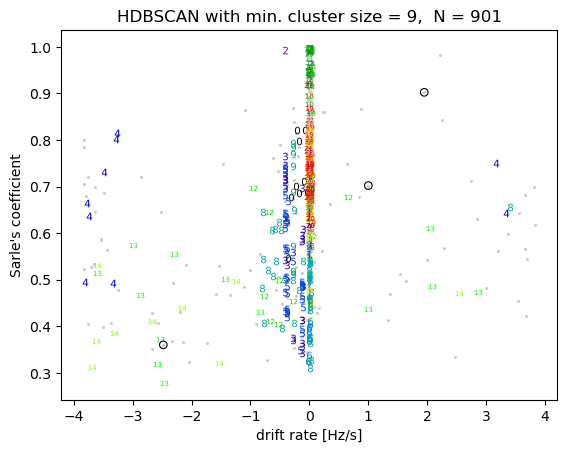

In [263]:
# SECOND HDBSCAN FOR ANOMALIES ONLY

nmincluster = 9
nminsamples = 2
eps = 0

col_idx_x = 0
col_idx_y = 2

hdb2 = HDBSCAN(min_cluster_size=nmincluster, min_samples=nminsamples, cluster_selection_epsilon=eps, cluster_selection_method='leaf')

X = np.transpose(data_arr)
#hdb2.fit(np.concatenate((X[:,1:], X[:,2:]), axis=1))
#hdb2.fit(X[:,1:])
hdb2.fit(X[np.where(labels_list == -1)[0]])

print(np.shape(X))

print('Making labels ...')
labels_list2 = hdb2.labels_
labels2 = np.unique(labels_list2)
print(len(labels))

x_param = dfu.columns[col_idx_x]
y_param = dfu.columns[col_idx_y]

x2 = dfu[x_param].values[np.where(labels_list == -1)[0]]
y2 = dfu[y_param].values[np.where(labels_list == -1)[0]]

colors = cm.nipy_spectral(np.linspace(0, 1, len(labels)-1))

print('Scattering ...')
for l in labels:
    idxs = np.where(labels_list2 == l)[0]
    if l == -1.:
        plt.scatter(x2[idxs], y2[idxs], color='0.8', s=5, linewidths=0, label=f'n={len(idxs)}')
        print(len(idxs))
    else:
        plt.scatter(x2[idxs], y2[idxs], marker=f'${l}$', color=colors[l], s=30, linewidths=0, label=f'n={len(idxs)}')

#other_idxs = np.array([683, 691])
other_idxs = np.array([3068, 3069, 3070])
#other_idxs = np.where(labels_list==11)[0]
#other_idxs2 = np.where(labels_list==12)[0]

plt.scatter(x[other_idxs], y[other_idxs], facecolors='none', edgecolors='k', linewidths=0.8, s=30)
#plt.scatter(x[other_idxs2], y[other_idxs2], color='w', edgecolors='k', s=30, marker='X')

print('Refining ...')

if 'log10' in df.columns[col_idx_x]:
    plt.xscale('log')
else:
    plt.xscale('linear')
if 'log10' in df.columns[col_idx_y]:
    plt.yscale('log')
else:
    plt.yscale('linear')

plt.xlabel(x_param)
plt.ylabel(y_param)
plt.title(f'HDBSCAN with min. cluster size = {nmincluster},  N = {len(x2)}')

#leg = plt.legend(fontsize=8)
#for lh in leg.legendHandles: 
#    lh.set_alpha(1)
#    lh.set_sizes([30])
#plt.xscale('log')
#plt.yscale('log')

#plt.savefig(f'HDBSCAN_clustering_{col_idx_x}_{col_idx_y}.pdf')

plt.show()

In [247]:
print(x[np.where(labels_list2 == -1)[0]])

[1681.512325 1681.480398 1679.756461 1658.865026 1649.993608 1626.126301
 1626.121814 1626.107224 1626.077124 1625.36956  1625.062707 1624.91347
 1624.832518 1624.024522 1622.165578 1620.218808 1619.988032 1619.890053
 1619.243688 1618.25136  1618.211686 1618.164066 1589.739638 1576.138301
 1576.121303 1575.0983   1574.967145 1574.872301 1574.605301 1561.811869
 1561.523869 1561.471368 1560.054223 1557.437879 1557.111702 1556.933989
 1556.922026 1556.910785 1556.898864 1556.886022 1556.183309 1556.10603
 1555.991707 1555.976706 1555.923157 1555.809526 1555.806559 1555.762669
 1555.520982 1555.508996 1555.502992 1554.957897 1554.895888 1554.413853
 1554.40905  1554.248078 1553.773171 1553.74653  1553.70875  1553.698309
 1553.658858 1553.651262 1553.64519  1552.734502 1552.69266  1552.686499
 1552.595097 1552.258195 1550.990259 1550.983394 1550.431957 1548.71721
 1547.699557 1547.562709 1547.550709 1546.986978 1546.964104 1546.937416
 1546.914941 1546.844103 1546.836079 1546.824741 1546.

For anomalous hit index 3068, distance ranking is 0.5828119786532547.
For anomalous hit index 3069, distance ranking is 0.4802458045958686.
For anomalous hit index 3070, distance ranking is 0.7086124936166466.
For anomalous hit index 3068, distance ranking is 0.578770913433983.
For anomalous hit index 3069, distance ranking is 0.4802314701247133.
For anomalous hit index 3070, distance ranking is 0.7081434709569266.
For anomalous hit index 3068, distance ranking is 0.5712244408792533.
For anomalous hit index 3069, distance ranking is 0.4648464843767302.
For anomalous hit index 3070, distance ranking is 0.6969232719225211.
For anomalous hit index 3068, distance ranking is 0.5534769261527476.
For anomalous hit index 3069, distance ranking is 0.4619307610232929.
For anomalous hit index 3070, distance ranking is 0.6832955370496929.
For anomalous hit index 3068, distance ranking is 0.5515635476207499.
For anomalous hit index 3069, distance ranking is 0.4618275643524043.
For anomalous hit ind

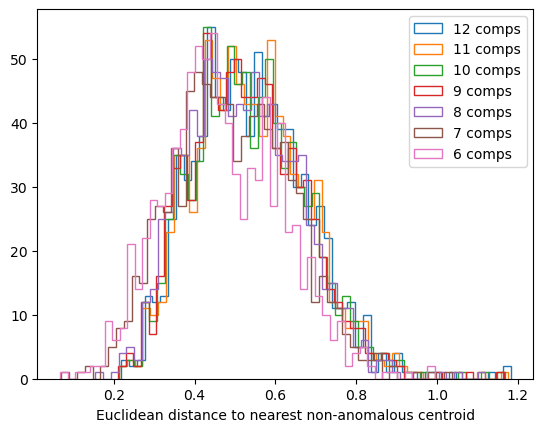

In [68]:
### CALCULATE EUCLIDEAN DISTANCE RANKING FOR ANOMALOUS HITS

X = np.transpose(data_arr)
centroids = hdb.centroids_

for i in [12,11,10,9,8,7,6]:

    pca = PCA(n_components=i, svd_solver='full')

    X_reduced = pca.fit_transform(X)

    distance_rankings = []

    for idx in np.where(labels_list == -1)[0]:

        params = X_reduced[idx]    # need to use normalized parameters

        distance_vec = []

        #for ii in np.where(labels_list != -1)[0]: # for each non-anomalous point ...
        #    
        #    nearby_params = X_reduced[ii]

        for centroid in centroids:

            nearby_params = pca.transform(centroid.reshape(1, -1))
            nearby_params = nearby_params.reshape(np.size(nearby_params))

            #calculate Euclidean distance between anomalous point and non-anomalous point
            diff_vec = params - nearby_params
            distance = np.sqrt(np.dot(diff_vec, diff_vec))

            distance_vec.append(distance)

        distance_vec = np.array(distance_vec)

        distance_ranking = np.min(distance_vec) # ranking is minimum Euclidean distance to a non-anomalous point
        distance_rankings.append(distance_ranking)

        if idx in [3068, 3069, 3070]:
            print(f'For anomalous hit index {idx}, distance ranking is {distance_ranking}.')

    distance_rankings = np.array(distance_rankings)

    plt.hist(distance_rankings, bins=50, histtype='step', label=f'{i} comps')
    
plt.legend()
plt.xlabel('Euclidean distance to nearest non-anomalous centroid')
plt.show()
    

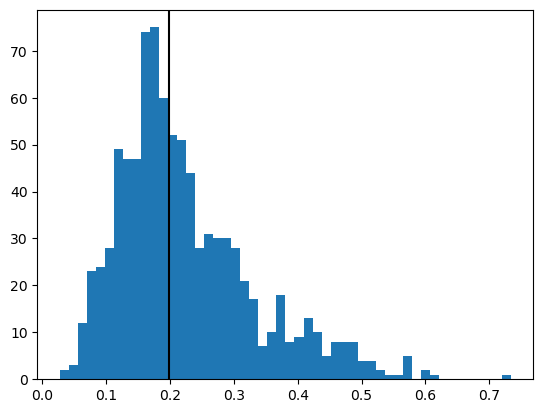

In [58]:
plt.hist(distance_rankings, bins=50)
plt.axvline(np.median(distance_rankings), color='k')
plt.show()

In [237]:
sii = np.argsort(distance_rankings)
sorted_idxs = np.where(labels_list == -1)[0][sii]
print(distance_rankings[sii])
print(sorted_idxs)

[0.20190138 0.20211593 0.20212891 0.20261777 0.20456217 0.20501483
 0.20504226 0.20510602 0.2053517  0.20780801 0.20824247 0.20850122
 0.20914791 0.20975932 0.21027993 0.2103058  0.2112709  0.21239923
 0.21253668 0.21282946 0.21310571 0.21448961 0.21450528 0.2149859
 0.21518139 0.21580397 0.21581093 0.21704396 0.21832439 0.21962488
 0.22063352 0.2208371  0.22182755 0.22212895 0.22217769 0.22256621
 0.22422826 0.22435564 0.22505134 0.22601162 0.22740397 0.22856774
 0.22901893 0.22926951 0.2294896  0.23050327 0.23134939 0.23162192
 0.23185331 0.23197988 0.23221409 0.2336695  0.23413632 0.23593998
 0.23696653 0.23829313 0.23891468 0.24048153 0.2408581  0.24162484
 0.24226531 0.24262939 0.24377195 0.24429489 0.24434954 0.24435152
 0.24527272 0.24613659 0.24719988 0.24762205 0.24912244 0.25027459
 0.25073627 0.25127164 0.25370837 0.25426466 0.25460099 0.25467625
 0.25673739 0.25710437 0.2571095  0.25833573 0.25913388 0.26068678
 0.26162518 0.26177155 0.26379005 0.26406712 0.26415317 0.26488

In [238]:
np.savez(f'/datax/scratch/benjb/sorted_anomalous_idxs_setigen__{nmincluster}_{nminsamples}_{eps}.npz', sorted_idxs)
np.savez(f'/datax/scratch/benjb/sorted_distance_rankings_setigen_{nmincluster}_{nminsamples}_{eps}.npz', distance_rankings[sii])

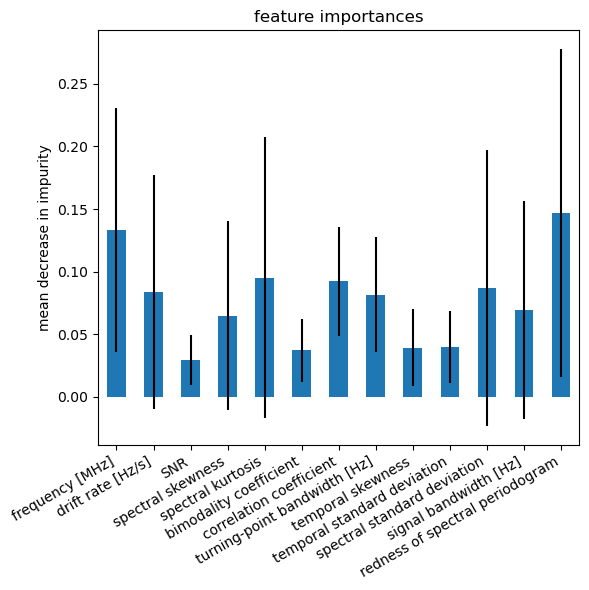

In [99]:
### RANDOM FOREST FOR FEATURE IMPORTANCES

from sklearn.model_selection import train_test_split

y = labels_list

#X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)
X_train = X
y_train = labels_list

from sklearn.ensemble import RandomForestClassifier

#feature_names = [f"feature {i}" for i in range(X.shape[1])]
feature_names = dfu.columns
forest = RandomForestClassifier(128, random_state=0)
forest.fit(X_train, y_train)

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots(figsize=(6,6))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("feature importances")
ax.set_ylabel("mean decrease in impurity")
plt.xticks(rotation=30, ha="right")
fig.tight_layout()
plt.show()
#plt.savefig('HDBSCAN_feature_importances.pdf')

In [100]:
tree_importances = np.array([tree.feature_importances_ for tree in forest.estimators_])

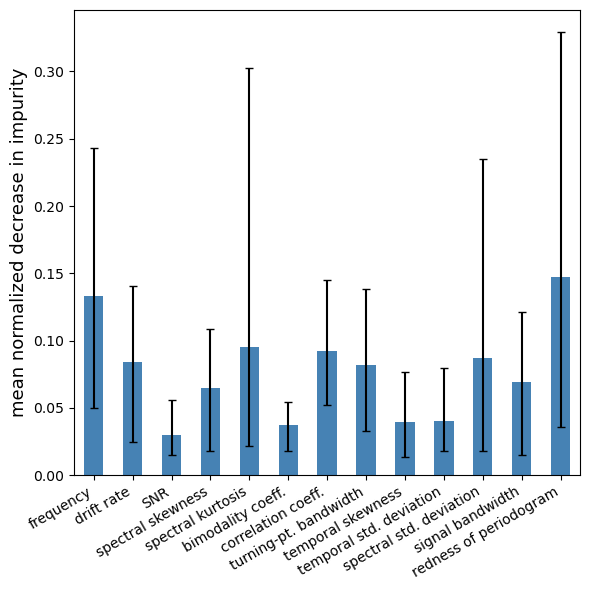

In [101]:
feature_names = ['frequency', 
                'drift rate', 
                'SNR', 
                'spectral skewness', 
                'spectral kurtosis', 
                'bimodality coeff.', 
                'correlation coeff.', 
                'turning-pt. bandwidth', 
                'temporal skewness', 
                'temporal std. deviation', 
                'spectral std. deviation',
                'signal bandwidth',
                'redness of periodogram']
importances = np.mean(tree_importances, axis=0)
err_neg = importances - np.quantile(tree_importances, 0.16, axis=0)
err_pos = np.quantile(tree_importances, 0.84, axis=0) - importances

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots(figsize=(6,6))
forest_importances.plot.bar(yerr=[err_neg, err_pos], ax=ax, color='steelblue', capsize=3)
#ax.set_title("feature importances")
ax.set_ylabel("mean normalized decrease in impurity", size=13)
plt.xticks(rotation=30, ha="right")
fig.tight_layout()
plt.savefig('HDBSCAN_feature_importances_3387_toy_dataset_new_redness.pdf', bbox_inches='tight')
plt.show()

In [24]:
print(np.sum(importances))

1.0


In [118]:
print(tree_importances[:,10])

[0.02975704 0.02883946 0.02843987 0.02726031 0.02546886 0.03644872
 0.02012033 0.04896656 0.01931403 0.0828006  0.03928266 0.0292939
 0.03614575 0.02763203 0.03251121 0.02554381 0.02579307 0.02285388
 0.06659232 0.25153145 0.24028525 0.02171567 0.01419781 0.05108396
 0.03462606 0.04521275 0.02499316 0.02735235 0.07530289 0.02186133
 0.26036498 0.02468921 0.24579889 0.23274948 0.24275311 0.01851695
 0.02114066 0.23866199 0.02371564 0.02499541 0.03071177 0.26984465
 0.23451922 0.24438938 0.03000962 0.24743795 0.05151569 0.0301398
 0.04930266 0.02652431 0.06084229 0.25195185 0.02886921 0.23952737
 0.26698748 0.03352673 0.24686535 0.08681358 0.01910582 0.02749571
 0.03365281 0.01836573 0.04271893 0.03558734 0.0250917  0.10131742
 0.04156659 0.23529145 0.23581956 0.02312853 0.05487835 0.23953963
 0.25654706 0.32863794 0.24896611 0.02179152 0.02777096 0.24657528
 0.02885088 0.0391676  0.04149129 0.02804899 0.05456983 0.24233595
 0.26049415 0.02518185 0.02172838 0.25867984 0.23993327 0.032865

In [130]:
a = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 9.25, 9.5, 9.75, 10.45, 10.25]
np.random.shuffle(a)

print(a)
print(np.quantile(a, 0.16))
median = np.median(a)
print(median)
print(np.quantile(a, 0.84))

print(np.mean(a) - np.quantile(a, 0.16))
print(np.quantile(a, 0.84) - np.mean(a))

[5, 1, 7, 10.45, 9.5, 9.75, 10.25, 4, 2, 0, 9.25, 9, 3, 10, 8, 6]
2.4
7.5
9.9
4.112500000000001
3.3875


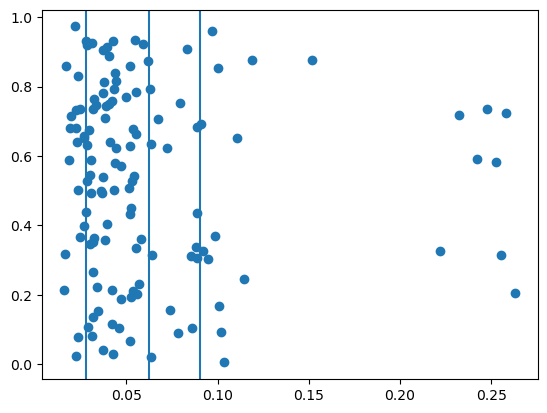

In [131]:
idx = 3

plt.scatter(tree_importances[:,idx], np.random.random(len(tree_importances[:,idx])))
#plt.axvline(np.quantile(tree_importances[:,idx], 0.25))
#plt.axvline(np.median(tree_importances[:,idx]))
#plt.axvline(np.quantile(tree_importances[:,idx], 0.75))
plt.axvline(np.mean(tree_importances[:,idx]))
plt.axvline(np.quantile(tree_importances[:,idx], 0.16))
plt.axvline(np.quantile(tree_importances[:,idx], 0.84))
plt.show()